# Robustness Noise SVD and Finite Differences
In order to understand the results better from the testing so far, in particular the plots, we want to analyse how noise influences our computations.
This serves the overall goal of improving our method with noisy data.
Following questions arise:

How can we bound the finite difference method?

How stable is the SVD to noise?

We only consider noise which is normally distributed? Does this influence our result?

What is the relation between the highest and the lowest singular value? Do they grow/shrink in a similar way when confronted with noise?

In [67]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import pysindy as ps
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d

In [2]:
from error_bounds import *
from test_data import create_data_2d

## SVD Robustness Noise
There is a theorem and a corollary:

Theorem 2.18 (Mirsky). If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\sqrt{\sum_{k=1}^{r}|\sigma_k(A+E) - \sigma_k(A)|} \leq \lVert E \rVert_F$

Corollary:
If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\forall k \ |\sigma_k(A+E) - \sigma_k(A)| \leq \lVert E \rVert$

#### 1. What is the spectral and Frobenius norm of random noise matrices?

In [3]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -10,10
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
#matrix[:, 1] = alpha*matrix[:,2]
#matrix[:, 1] = 1e-12*matrix[:,1]
print(matrix)

[[-8.06880736  2.3422199   0.56736414]
 [ 0.83126959  0.42380215 -8.30422591]
 [ 1.72700729  6.990022    8.3407002 ]
 [ 0.37655276  9.81084636  2.60071907]
 [-7.51815119  4.75136658  6.80185661]
 [ 0.0677224   1.44832064  3.01319799]
 [ 5.8384263   4.71770274  5.669118  ]
 [-2.39227494  2.77904322  5.72996395]
 [-6.71856928  8.46868976 -3.95269164]
 [-2.15342814 -8.59423318 -2.17222234]]


In [4]:
sv=svd(matrix, compute_uv=False)
print(matrix_rank(matrix),sv)
print(sv[0]/sv[-1])
print(np.linalg.norm(matrix))
print(np.linalg.norm(matrix,ord=2))

3 [21.79558696 15.19514848 12.09864727]
1.801489577889832
29.19447574307333
21.79558695731566


Add noise

In [5]:
#np.random.seed(12)
target_noise=1e-3
var = target_noise * np.sqrt(np.mean(np.square(matrix)))
noise = np.random.normal(0, var, size=matrix.shape)
matrix_noise = matrix + noise
print(f"Added Gaussian noise with variance {var}")

Added Gaussian noise with variance 0.005330157639672887


In [6]:
print("Noise Matrix")
print(f"Matrix rank: {matrix_rank(noise)}, SVD: {svd(noise, compute_uv=False)}")
print(f"Frobenius norm:\t {np.linalg.norm(noise)}")
print(f"Spectral norm:\t {np.linalg.norm(noise,ord=2)}")

Noise Matrix
Matrix rank: 3, SVD: [0.01925512 0.01381172 0.00930666]
Frobenius norm:	 0.025458537361237744
Spectral norm:	 0.019255123049312973


Print SVD and matrix rank with additional noise

In [7]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t \t matrix rank \t svd \t \t \t \t \t \t \t Frobenius \t \t \t Spectral")
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix + noise
    print(f" {target_noise}      \t \t {matrix_rank(matrix_noise)} \t \t {svd(matrix_noise, compute_uv=False)}     \t {np.linalg.norm(noise)}      \t {np.linalg.norm(noise,ord=2)}")

Noise level 	 	 matrix rank 	 svd 	 	 	 	 	 	 	 Frobenius 	 	 	 Spectral
 0      	 	 3 	 	 [21.79558696 15.19514848 12.09864727]     	 0.0      	 0.0
 1e-10      	 	 3 	 	 [21.79558696 15.19514848 12.09864727]     	 3.0629376181398635e-09      	 2.2171887641957754e-09
 1e-09      	 	 3 	 	 [21.79558696 15.1951485  12.09864727]     	 2.9751330306087845e-08      	 2.5159058636574425e-08
 1e-08      	 	 3 	 	 [21.79558699 15.19514855 12.09864728]     	 2.848436326682412e-07      	 2.0524582462425482e-07
 1e-07      	 	 3 	 	 [21.79558816 15.19514856 12.09864743]     	 3.1724091046738235e-06      	 2.744413365111293e-06
 1e-06      	 	 3 	 	 [21.79558218 15.19514166 12.09864984]     	 3.2307015536685403e-05      	 2.656649333462596e-05
 1e-05      	 	 3 	 	 [21.79552563 15.19518201 12.09865828]     	 0.0003104631378352226      	 0.00023397189138508415
 0.0001      	 	 3 	 	 [21.79582283 15.19535444 12.09807544]     	 0.002487142307060607      	 0.0017733069271458689
 0.001      	 	 3 	 	 [

Although the Frobenius Norm might not be that high in relation to the highest singular value. In relation to the smallest singular value it can be quite significant. Thus, the **changes in the smallest singular value can be more disturbing** for our purpose.

#### 2. What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $\frac{\sigma_1}{\sigma_m} < \infty$, but if it does not have full rank $\frac{\sigma_1}{\sigma_m} = \infty$

The bound that we use in the following is for $ \|B\|=max(\frac{1}{\sigma_n},\frac{\sigma_1}{\sigma_n^2}), \ \|B\|_F^2=\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2$
\begin{equation}
    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | < \|B\|\|E\|
\end{equation}
<font color='red'>Note this bound does not include the supremum in the condition</font>. Thus it is not technically correct but it might be a well enough approximation to the real bound.

In [10]:
# This calculates the above given bound
def calc_bound_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2
    return E*B

In [11]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
#matrix = np.random.random(size=(rows,cols))
alpha = np.random.rand()
print(alpha)
#matrix[:, 1] = matrix[:,2]
#matrix[:,0] = np.random.rand()*matrix[:,2]
#matrix[:, 2] *=1e6
#matrix[:, 0] *=1e6
print(matrix)

0.44069504250902036
[[-0.76734188 -2.8466718  -2.58202401]
 [-0.30097483 -0.15035728 -2.57858092]
 [-3.3539588  -3.37614312 -3.68269517]
 [-4.01320663 -4.15168726 -2.9061794 ]
 [-1.94601972 -3.90209648 -4.5706079 ]
 [ 0.29008778 -4.88119079 -2.32798456]
 [ 0.90687857  0.11655787 -1.40416407]
 [-2.28078997 -4.29250557 -0.8375185 ]
 [ 0.48975259  0.69541388  0.12314933]
 [-4.71738271 -1.94184342 -1.63233051]]


In [13]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio biggest/smallest singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [13.81798167  4.71197522  3.57460434]
Ratio biggest/smallest singular value: 3.8655975159803346
Bound: 0.0


In [16]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t diff \t \t bound")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    diff = np.abs(ratio-sv_max/sv_min)
    bound=calc_bound_ratio(sv_max,sv_min,noise)
    differences.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t \t\t{ratio:3.3e} \t {diff:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 diff 	 	 bound
 0	 	 3 	 	 [13.81798167  4.71197522  3.57460434] 	 		3.866e+00 	 0.000e+00  	 0.000e+00
 1e-10	 	 3 	 	 [13.81798167  4.71197522  3.57460434] 	 		3.866e+00 	 2.902e-10  	 1.545e-09
 1e-09	 	 3 	 	 [13.81798167  4.71197522  3.57460434] 	 		3.866e+00 	 8.907e-10  	 1.505e-08
 1e-08	 	 3 	 	 [13.81798171  4.71197517  3.57460434] 	 		3.866e+00 	 1.618e-08  	 1.495e-07
 1e-07	 	 3 	 	 [13.81798179  4.71197518  3.57460396] 	 		3.866e+00 	 4.495e-07  	 1.171e-06
 1e-06	 	 3 	 	 [13.81798232  4.71198024  3.57461008] 	 		3.866e+00 	 6.027e-06  	 9.122e-06
 1e-05	 	 3 	 	 [13.81798     4.71196349  3.57462467] 	 		3.866e+00 	 2.245e-05  	 8.685e-05
 0.0001	 	 3 	 	 [13.81805523  4.71192351  3.57456174] 	 		3.866e+00 	 6.665e-05  	 1.300e-03
 0.001	 	 3 	 	 [13.81989455  4.71257314  3.57828145] 	 		3.862e+00 	 3.438e-03  	 1.330e-02
 0.01	 	 3 	 	 [13.8320655   4.72833905  3.53772346] 	 		3.910e+00 	 4.428e-02  	 1.268e-01
 0.1	

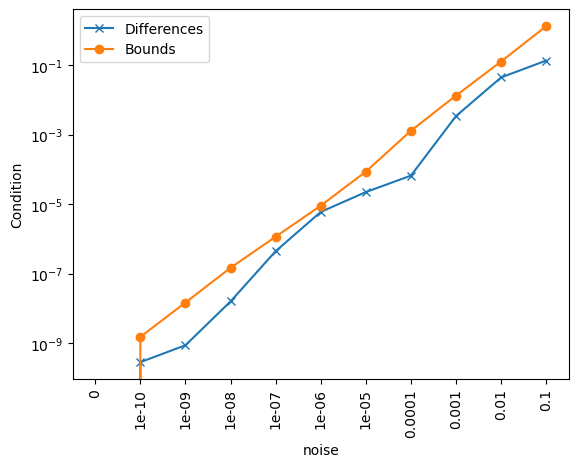

In [21]:
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(range(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.ylabel('Condition')
plt.xlabel('noise')
plt.legend()

Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [22]:
trials=10
noise_level=1e-10
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t \t \t  ratio \t \t bound \t \t \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}   \t  {ratio:3.3e}   \t \t {bound:3.3e} \t \t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  1e-10, Number trials: 10, True ratio: 3.8655975159803346
Trial 	 matrix rank 	 sv 	 	 	 	 	 	 	  ratio 	 	 bound 	 	 	 difference
 0	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.854e-09 	 	 2.432e-10
 1	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.013e-09 	 	 5.356e-10
 2	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.570e-09 	 	 1.143e-10
 3	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.482e-09 	 	 1.758e-10
 4	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.540e-09 	 	 4.211e-10
 5	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.236e-09 	 	 4.004e-12
 6	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.682e-09 	 	 2.384e-10
 7	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.159e-09 	 	 1.641e-10
 8	 	 3 	 [13.81798167  4.71197522  3.57460434]   	  3.866e+00   	 	 1.293e-09 	 	 2.443e-11
 9	 	 3 	 [13.81798

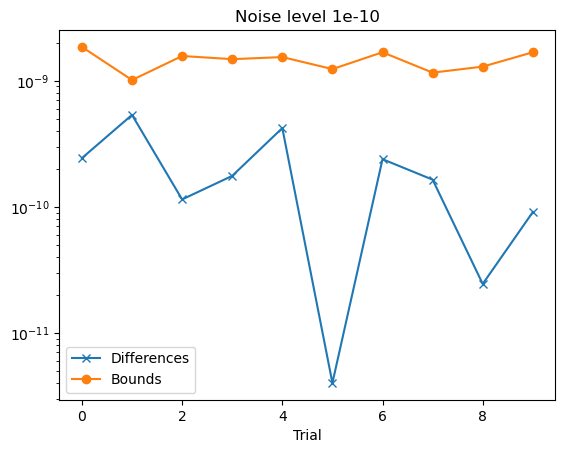

In [24]:
plt.title(f"Noise level {noise_level}")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.yscale('log')
plt.xlabel('Trial')
plt.legend()

Plot range of sv_max/sv_min: $$\max(0,\frac{\sigma_1(A)}{\sigma_n(A)}  - \|B\|\|E\|) <\frac{\sigma_1(A+E)}{\sigma_n(A+E)} < \frac{\sigma_1(A)}{\sigma_n(A)} | + \|B\|\|E\|$$

In [25]:
"""
This returns two values
  lower_bound: omax/omin -BE
  upper_bound: BE + omax/min
"""
def calc_range_ratio(sv_max,sv_min,noisematrix):
    #E=np.linalg.norm(noisematrix) #Spectral: order=2, Frobenius: default
    B=np.sqrt(1/sv_min+(sv_max/sv_min**2)**2)
    E=np.linalg.norm(noisematrix,ord=2) #Spectral: order=2, Frobenius: default
    lower_bound=max(0,sv_max/sv_min - B*E)
    upper_bound=B*E + sv_max/sv_min
    return lower_bound, upper_bound

In [26]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:, 1] *=1e-6
#matrix[:, 1] = matrix[:,2]
print(matrix)

0.5192218501862896
[[ 1.75794557e-01  2.87481668e-07 -3.42594126e+00]
 [ 1.36052585e-01  6.61674631e-07 -2.78792203e+00]
 [-4.81996269e+00  2.45878008e-07  5.82176048e-01]
 [ 1.96735987e-01 -1.79639707e-06  8.16118275e-01]
 [ 3.14670274e-01 -3.65188731e-06 -3.57314655e+00]
 [ 7.70765608e-01  2.17995779e-07 -2.54067595e+00]
 [-1.25790769e+00 -7.80759429e-07 -2.83178698e+00]
 [-4.20835513e+00 -3.90691909e-07 -2.60689407e+00]
 [ 3.93360913e-01 -2.38887284e-06 -6.38214699e-01]
 [-1.86812518e+00 -2.38279429e-06  3.55849174e-01]]


In [28]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio big/smallest singular value: {sv[0]/sv[-1]}")
print(f"Bound: {calc_bound_ratio(sv_max,sv_min,np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 3
Singular values : [7.68337303e+00 6.55759685e+00 5.14856204e-06]
Ratio big/smallest singular value: 1492333.7776817547
Bound: 0.0


In [29]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t \t \t \t ratio \t \t bound")
ratios =[]
ups,lows =[],[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound = calc_bound_ratio(sv_max,sv_min,noise)
    bounds.append(bound)
    low,up=calc_range_ratio(sv_max,sv_min,noise)
    ratios.append(ratio)
    lows.append(low)
    ups.append(up)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv}   \t  \t{ratio:3.3e}  \t {bound:3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	 	 	 	 ratio 	 	 bound
 0	 	 3 	 	 [7.68337303e+00 6.55759685e+00 5.14856204e-06]   	  	1.492e+06  	 0.000e+00
 1e-10	 	 3 	 	 [7.68337303e+00 6.55759685e+00 5.14848148e-06]   	  	1.492e+06  	 2.652e+02
 1e-09	 	 3 	 	 [7.68337303e+00 6.55759685e+00 5.14918891e-06]   	  	1.492e+06  	 2.014e+03
 1e-08	 	 3 	 	 [7.68337308e+00 6.55759682e+00 5.14909292e-06]   	  	1.492e+06  	 3.009e+04
 1e-07	 	 3 	 	 [7.68337305e+00 6.55759696e+00 4.90418229e-06]   	  	1.567e+06  	 1.907e+05
 1e-06	 	 3 	 	 [7.68337640e+00 6.55759613e+00 7.76242764e-06]   	  	9.898e+05  	 1.890e+06
 1e-05	 	 3 	 	 [7.68337229e+00 6.55757124e+00 5.14194945e-05]   	  	1.494e+05  	 1.899e+07
 0.0001	 	 3 	 	 [7.68324991e+00 6.55805657e+00 6.47248655e-04]   	  	1.187e+04  	 2.591e+08
 0.001	 	 3 	 	 [7.68550260e+00 6.55733499e+00 3.05579461e-03]   	  	2.515e+03  	 1.517e+09
 0.01	 	 3 	 	 [7.64429701 6.55041199 0.04913316]   	  	1.556e+02  	 2.184e+10
 0.1	 	 3 	 	 [7.49624606 6.36971

In [30]:
print(lows)
print(ups)

[1492333.7776817547, 1492068.541416494, 1490319.4929627767, 1462240.555172882, 1301618.9440254287, 0, 0, 0, 0, 0, 0]
[1492333.7776817547, 1492599.0139470154, 1494348.0624007327, 1522427.0001906273, 1683048.6113380806, 3382648.7469112175, 20479274.389762014, 260628913.04127568, 1518681899.140778, 21841295269.009914, 212707541966.2206]


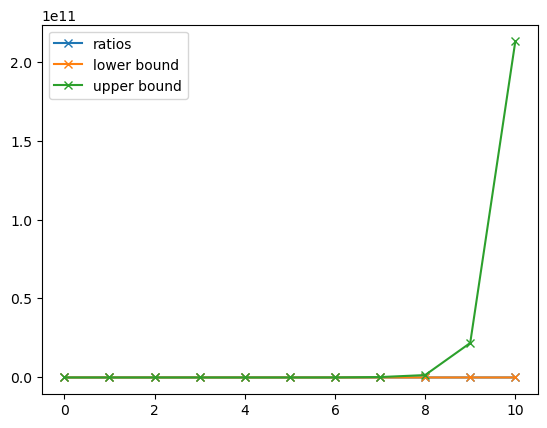

In [31]:
plt.plot(ratios,marker='x',label="ratios")
plt.plot(lows,marker='x',label="lower bound")
plt.plot(ups,marker='x',label="upper bound")
plt.legend()
#plt.yscale('log')

## Finite Difference Noise

We can find the coefficients use to calculate the finite differences for different orders in https://en.wikipedia.org/wiki/Finite_difference_coefficient or in the calculator https://web.media.mit.edu/~crtaylor/calculator.html<br>
Assuming we have equispaced data for x,and we can bound the measurement error by $\epsilon > 0$ i.e. $||u-\tilde{u}||_{\infty}< \epsilon$ and the third derivative of u
is bounded by $M(t, x) > 0$ on each interval $[x − h, x + h]$. Then, we get that
$$|u_x(t, x) − \tilde{u}_x(t, x)| ≤ \frac{\epsilon}{h} + \frac{h^2}{6}M(t,x)$$
is the 2nd order centered finite differences approximation of the derivative of $\tilde{u}$.

Question: do the same error bounds count at the boundary values of u? For centered Differences this is not the case. This can lead to wrong errorbounds especially at the boundary values.

Pysindy uses for even order: centered differenced, for uneven order: backward differences:<br>
order = 1: <br>
Approximation: $\frac{u(x)-u(x-h)}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h}{2}||u'||_{\infty}+\frac{2\epsilon}{h}$ 
<br>
order = 2: <br>
Approximation: $\frac{u(x+\frac{h}{2})-u(x-\frac{h}{2})}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^2}{3}||u^3||_{\infty}+\frac{2\epsilon}{h}$ <br>
(Here we use h/2 since for h the calculation did not work out -> makes more sense???)<br>
order = 4: <br>
Approximation: see book or wiki,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^4}{30}||u^5||_{\infty}+\frac{9 \epsilon}{6h}$ <br>

In [32]:
#Create data
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)


a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
dx=x[1]-x[0]

In [4]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [1.44484004e+06 5.75819370e-01]


### Check difference between noisy derivative and correct derivative

To approximate $\|u'-\tilde{u}'\|$

General formula for central differences: $$ \text{sum over coefficients} \frac{\epsilon}{h} + h^{order} \|u^{order+1}\|_{\infty}\frac{(order/2)!^2}{(order+1)!}$$

For backward differences: $$ \text{sum over coefficients}\frac{\epsilon}{h} + h^{order}\|u^{order+1}\|_{\infty} \frac{1}{order+1}$$

The sum over coefficients is the sum over the derivative of the  Lagrange polynomial coefficients:
$$L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$$
$$  L'_{n,k}(x) = [\prod_{i=0,i\neq k}^n \frac{1}{x_k-x_i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (x-x_i)
$$
$$  L'_{n,k}(x_l)= h^{-1}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (l-i) = h^{-1} \sum_{j=0,j\neq k}^n \frac{1}{k-j} \prod_{i=0,i\neq k,j}^n \frac{l-i}{k-i}$$
Note here n stands for the order as well. (wiki link to polynomial and derivatives: https://en.wikipedia.org/wiki/Lagrange_polynomial).
The functions for calculating this is in error_bounds.py

#### Plots for analysining the "knick" in finite differences error

The Measurment error increases while the approximation error decreases. If in the beginning the measurment error is strictly smaller than the approximation error this can lead to the "knick". If not than no "knick" should be visible.

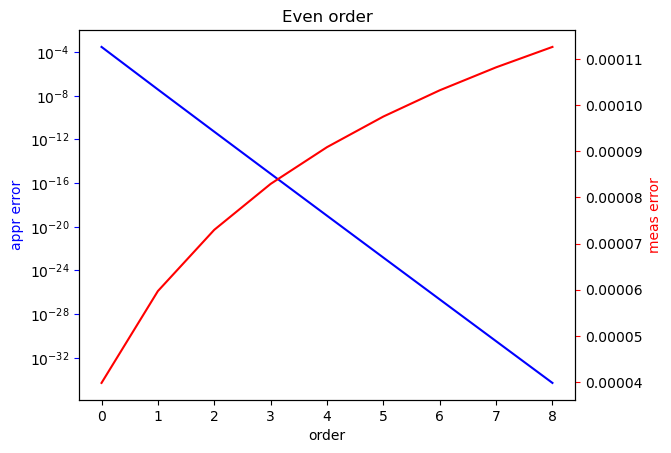

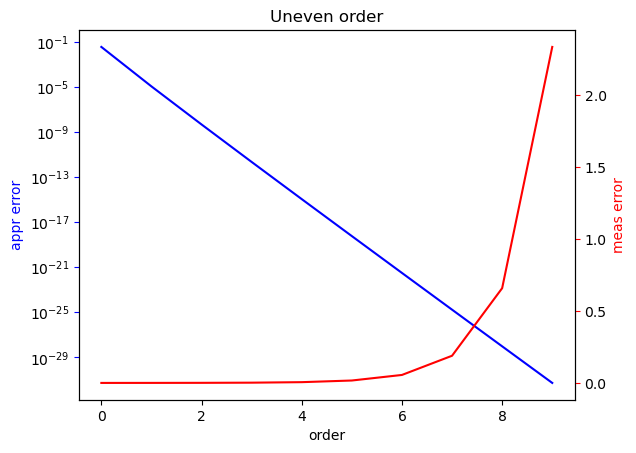

In [33]:
meas_error_list_even=[]
app_error_list_even=[]
meas_error_list_uneven=[]
app_error_list_uneven=[]
h=dx
eps=1e-6#np.finfo(float).eps # if this is big enough no knick will be visible, note it mus be very small for the knick to be visple
M=2.78
for order in range(1,20,1):
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)*h**order*M
        C_meas=meas_error_central_diff(order)*eps/h
        app_error_list_even.append(C_app)
        meas_error_list_even.append(C_meas)
    else: # odd order
        C_app=appr_error_backward_diff(order)*h**order*M
        C_meas=meas_error_backward_diff(order)*eps/h
        app_error_list_uneven.append(C_app)
        meas_error_list_uneven.append(C_meas)

fig, ax1 = plt.subplots()
plt.title("Even order")
ax1.set_xlabel('order')
color = 'blue'
ax1.set_ylabel('appr error', color=color)
ax1.plot(app_error_list_even,color=color)
ax1.tick_params(axis='y', color=color)
plt.yscale('log')

ax2 = ax1.twinx()  
color='red'
ax2.set_ylabel('meas error', color=color)  
ax2.plot(meas_error_list_even, color=color)
ax2.tick_params(axis='y', color=color)

fig, ax1 = plt.subplots()
plt.title("Uneven order")
ax1.set_xlabel('order')
color = 'blue'
ax1.set_ylabel('appr error', color=color)
ax1.plot(app_error_list_uneven,color=color)
ax1.tick_params(axis='y', color=color)
plt.yscale('log')

ax2 = ax1.twinx()  
color='red'
ax2.set_ylabel('meas error', color=color)  
ax2.plot(meas_error_list_uneven, color=color)
ax2.tick_params(axis='y', color=color)

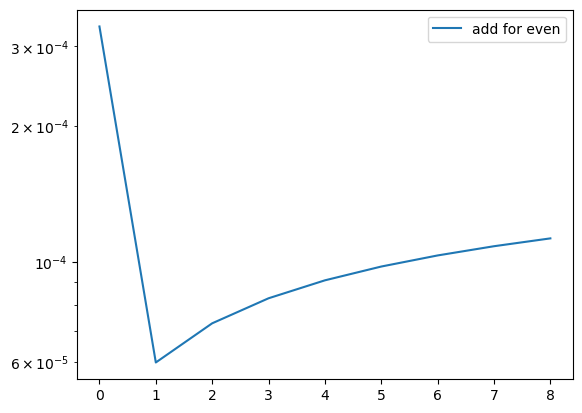

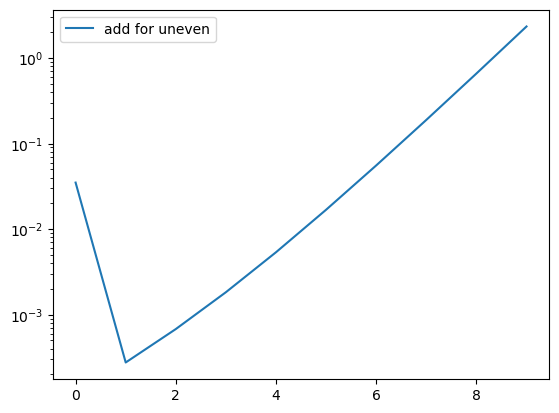

In [34]:
combined_list = [x + y for x, y in zip(meas_error_list_even, app_error_list_even)]
plt.plot(combined_list,label='add for even')
plt.legend()
plt.yscale('log')
plt.show()
combined_list = [x + y for x, y in zip(meas_error_list_uneven, app_error_list_uneven)]
plt.plot(combined_list,label='add for uneven')
plt.yscale('log')
plt.legend()

#### Analysis of Noise on derivative

##### With Boundary values

Noise level 	  eps 	 	 $max|ux-ux_noise|$ 	 bound
0 	 	  0.0000 	 0.0306 	 	 0.0156
1e-10 	 	  0.0000 	 0.0306 	 	 0.0156
1e-09 	 	  0.0000 	 0.0306 	 	 0.0156
1e-08 	 	  0.0000 	 0.0306 	 	 0.0157
1e-07 	 	  0.0000 	 0.0305 	 	 0.0160
1e-06 	 	  0.0001 	 0.0311 	 	 0.0197
1e-05 	 	  0.0010 	 0.0803 	 	 0.0537
0.0001 	 	  0.0099 	 0.7417 	 	 0.4091
0.001 	 	  0.0945 	 7.1538 	 	 3.7759
0.01 	 	  1.0775 	 65.6466 	 	 42.9006
0.1 	 	  10.0661 	 625.1456 	 	 400.6446


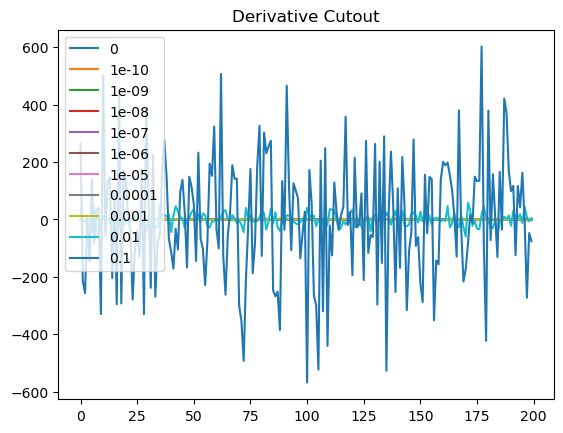

In [37]:
# noise analysis for one specific order
order=2
M=infinity_norm(uxxx)
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t  eps \t \t $max|ux-ux_noise|$ \t bound")
plt.title("Derivative Cutout")

for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    plt.plot(ux_noise[0,:],label=str(target_noise))
    eps = infinity_norm(u_noise-u)
    bound = error_bound_finite_diff(eps,dx,M,order)
    diff = infinity_norm(ux-ux_noise)
    print(f"{target_noise} \t \t  {eps:.4f} \t {diff:.4f} \t \t {bound:.4f}")
plt.legend()
plt.show()

In [38]:
#Noise analysis for orders in specific range
orders=range(1,10,1)
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        eps = infinity_norm(u_noise-u)
        bound = error_bound_finite_diff(eps,dx,M,order)
        diff = infinity_norm(ux-ux_noise)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 1.8490 	 1.8645
	 1e-10	 	  0.000 	 1.8490 	 1.8645
	 1e-09	 	  0.000 	 1.8490 	 1.8645
	 1e-08	 	  0.000 	 1.8490 	 1.8646
	 1e-07	 	  0.000 	 1.8489 	 1.8652
	 1e-06	 	  0.000 	 1.8503 	 1.8724
	 1e-05	 	  0.001 	 1.8543 	 1.9484
	 0.0001	 	  0.009 	 2.0673 	 2.5649
	 0.001	 	  0.090 	 5.5782 	 9.0126
	 0.01	 	  1.030 	 55.9058 	 83.8327
2
	 0	 	  0.000 	 0.0306 	 0.0156
	 1e-10	 	  0.000 	 0.0306 	 0.0156
	 1e-09	 	  0.000 	 0.0307 	 0.0156
	 1e-08	 	  0.000 	 0.0306 	 0.0157
	 1e-07	 	  0.000 	 0.0306 	 0.0160
	 1e-06	 	  0.000 	 0.0329 	 0.0194
	 1e-05	 	  0.001 	 0.0776 	 0.0609
	 0.0001	 	  0.010 	 0.7037 	 0.4215
	 0.001	 	  0.090 	 7.9859 	 3.6114
	 0.01	 	  0.970 	 75.9926 	 38.6160
3
	 0	 	  0.000 	 0.0006 	 0.0006
	 1e-10	 	  0.000 	 0.0006 	 0.0006
	 1e-09	 	  0.000 	 0.0006 	 0.0006
	 1e-08	 	  0.000 	 0.0006 	 0.0008
	 1e-07	 	  0.000 	 0.0011 	 0.0031
	 1e-06	 	  0.000 	 0.0110 	 0.0253
	 1e-05	 	  0.

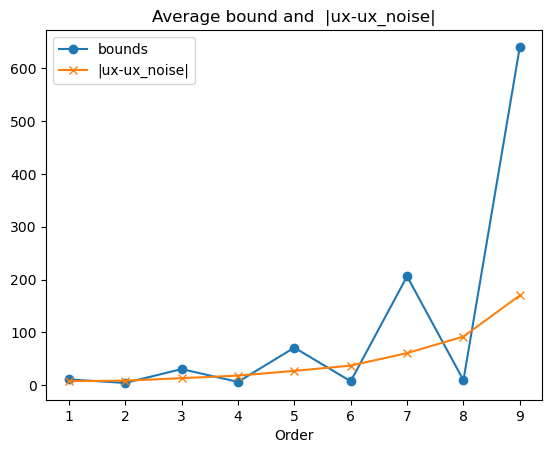

In [39]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

##### Without Boundary values

In [40]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound_finite_diff(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 1.8335 	 1.8645
	 1e-10	 	  0.000 	 1.8335 	 1.8645
	 1e-09	 	  0.000 	 1.8336 	 1.8645
	 1e-08	 	  0.000 	 1.8336 	 1.8646
	 1e-07	 	  0.000 	 1.8334 	 1.8653
	 1e-06	 	  0.000 	 1.8336 	 1.8719
	 1e-05	 	  0.001 	 1.8358 	 1.9455
	 0.0001	 	  0.010 	 2.0763 	 2.6890
2
	 0	 	  0.000 	 0.0152 	 0.0156
	 1e-10	 	  0.000 	 0.0152 	 0.0156
	 1e-09	 	  0.000 	 0.0152 	 0.0156
	 1e-08	 	  0.000 	 0.0152 	 0.0157
	 1e-07	 	  0.000 	 0.0153 	 0.0161
	 1e-06	 	  0.000 	 0.0153 	 0.0197
	 1e-05	 	  0.001 	 0.0313 	 0.0518
	 0.0001	 	  0.009 	 0.2702 	 0.3906
3
	 0	 	  0.000 	 0.0002 	 0.0006
	 1e-10	 	  0.000 	 0.0002 	 0.0006
	 1e-09	 	  0.000 	 0.0002 	 0.0006
	 1e-08	 	  0.000 	 0.0002 	 0.0008
	 1e-07	 	  0.000 	 0.0005 	 0.0031
	 1e-06	 	  0.000 	 0.0043 	 0.0269
	 1e-05	 	  0.001 	 0.0529 	 0.2506
	 0.0001	 	  0.010 	 0.4230 	 2.6911
4
	 0	 	  0.000 	 0.0000 	 0.0000
	 1e-10	 	  0.000 	 0.0000 	 0.0000
	 1e-09	 	  0.000

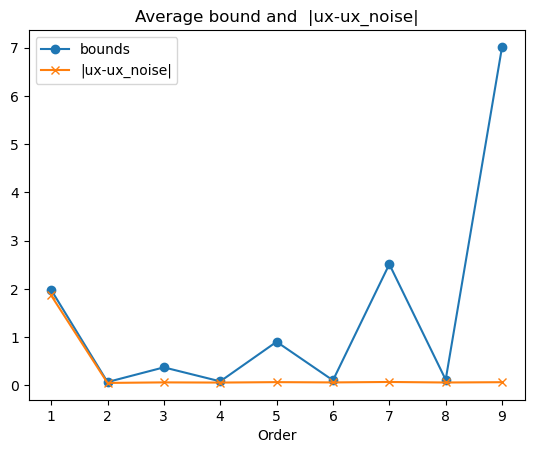

In [41]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

Plot accuracy and bound depending on error

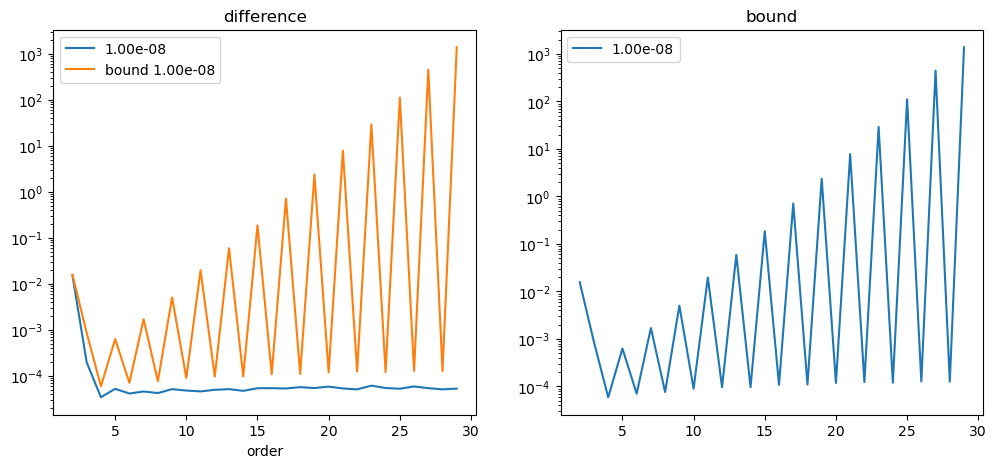

In [42]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [1e-8]#+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,30,1)
#print("Noise level \t Order \t  eps \t \t|ux-ux_noise| \t bound")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xlabel('order')
for target_noise in noise_levels:
    #print(f"{target_noise}")
    diff_list = []
    bound_list = []
    avg_diff=0
    avg_bound=0
    for order in orders:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound_finite_diff(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        diff_list.append(diff)
        bound_list.append(bound)
        #print(f"\t \t {order}\t \t  {eps:.5f} \t {diff:.5f} \t {bound:.5f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    plt.subplot(1,2,1)
    plt.title("difference")
    plt.plot(orders,diff_list,label = f"{target_noise:2.2e}")
    plt.plot(orders,bound_list,label = f"bound {target_noise:2.2e}")
    plt.legend()
    plt.yscale('log')
    plt.subplot(1,2,2)
    plt.yscale('log')
    plt.title("bound")
    plt.plot(orders,bound_list,label = f"{target_noise:2.2e}")
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)
plt.legend()    

### Nth derivative error

TODO: We should be able to calculate the error calculation of nth derivative on $u$ by finite differences recursively??? -> Does not work yet

In [47]:
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)

"""
a=np.random.randn()
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)

dx=x[1]-x[0]

In [48]:
"""
This should bound the error of finite differences on the nth derivative by a recursive schema
eps_infty:bounds the infinty norm norm max|u-u_noise|<=eps_infty
n: order of the derivative
order: order of the finite difference calculation
M: M must be the supremum over all ith derivative for i = n+order+1,n+order,...,order+1
"""
def error_bound_finite_diff_nth_derivative(eps_infty,n,order,M,h, C_app=None,C_meas=None):
    if n == 0:
        return eps_infty+np.finfo(float).eps
    #Only calculalate measurement and approximatin error once in the beginning 
    if C_app==None or C_meas==None:
        if order%2==0: #even order
            C_app=appr_error_central_diff(order)
            C_meas=meas_error_central_diff(order)
        else: # odd order
            C_app=appr_error_backward_diff(order)
            C_meas=meas_error_backward_diff(order)
        
    return error_bound_finite_diff_nth_derivative(eps_infty,n-1,order,M,h,C_app,C_meas)*(C_meas/h) + (h**order)*M*C_app


In [49]:
M=infinity_norm(uxxx)
number_derivative=2
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(number_derivative,10,1)
print("Order \t Noise level \t  eps \t \t|uxx-uxx_noise| \t bound")
diff_list = []
bound_list = []

for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        
        uxx_noise = ps.FiniteDifference(order=order,d=number_derivative, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(uxx_noise).all(axis=1)
        col_mask = ~np.isnan(uxx_noise).all(axis=0)
        
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound_finite_diff_nth_derivative(eps,number_derivative,order,M,dx)
        
        diff = infinity_norm(uxx[row_mask][:, col_mask]-uxx_noise[row_mask][:, col_mask])
        
        avg_bound+=bound
        avg_diff+=diff
        
        print(f"\t {target_noise}\t \t  {eps:.3e} \t {diff:.4e} \t {bound:.4e}")
        
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|uxx-uxx_noise| 	 bound
2
	 0	 	  0.000e+00 	 5.7864e-04 	 4.2928e-03
	 1e-10	 	  3.129e-10 	 5.7971e-04 	 4.2933e-03
	 1e-09	 	  3.071e-09 	 5.9647e-04 	 4.2977e-03
	 1e-08	 	  3.149e-08 	 8.3456e-04 	 4.3427e-03
	 1e-07	 	  3.494e-07 	 3.2880e-03 	 4.8463e-03
	 1e-06	 	  3.411e-06 	 2.2971e-02 	 9.6960e-03
	 1e-05	 	  3.001e-05 	 3.4990e-01 	 5.1822e-02
	 0.0001	 	  3.146e-04 	 2.4036e+00 	 5.0270e-01
3
	 0	 	  0.000e+00 	 5.2607e-05 	 1.0561e-03
	 1e-10	 	  3.120e-10 	 5.3418e-05 	 1.0781e-03
	 1e-09	 	  3.300e-09 	 6.3827e-05 	 1.2884e-03
	 1e-08	 	  3.196e-08 	 5.6094e-04 	 3.3061e-03
	 1e-07	 	  3.023e-07 	 4.6872e-03 	 2.2337e-02
	 1e-06	 	  3.568e-06 	 5.8051e-02 	 2.5226e-01
	 1e-05	 	  3.151e-05 	 4.5511e-01 	 2.2191e+00
	 0.0001	 	  3.019e-04 	 4.2752e+00 	 2.1255e+01
4
	 0	 	  0.000e+00 	 3.0329e-07 	 8.0637e-07
	 1e-10	 	  2.924e-10 	 1.1230e-05 	 1.8484e-06
	 1e-09	 	  3.198e-09 	 8.1035e-05 	 1.2205e-05
	 1e-08	 	  3.123e-08 	 9.8664e-04 	 1

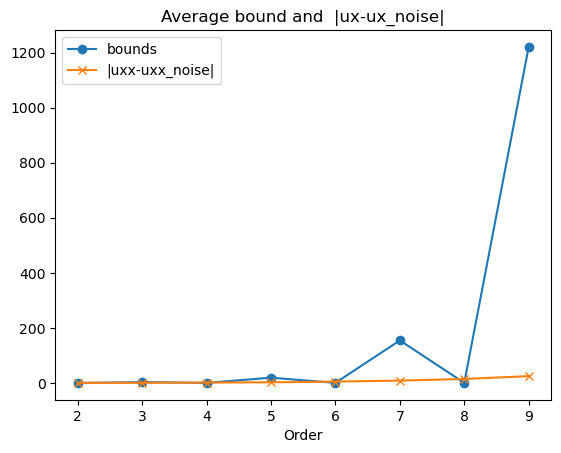

In [50]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|uxx-uxx_noise|')
plt.legend()

## Put everything together: Finite Differences and SVD

Let $\|g-\tilde{g}\|_F^2 = \sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \|u-\tilde{u}\|^2+ \sum_{i=2}^n m\text{ errorbound}({\alpha_i},\epsilon)^2 =E $
$$| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < \sqrt{(\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) E}$$

In [51]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()#*1e-6
"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]
print(f"{dx:2.3e}")

1.010e-02


In [61]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
true_ratio = sv_max/sv_min
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"True sv_max/sv_min: {true_ratio:3.3e}")

M: 2.718281828459045
Singular values of g: (186.4967295283271, 4.2845217525622065e-14)
True sv_max/sv_min: 4.353e+15


##### Check $\sum_{i=1}^{n}\|u_{\alpha_i}-\tilde{u}_{\alpha_i}\|^2 < \sum_{i=1}^n m \text{ errorbound}({\alpha_i},\epsilon)^2  $

In [53]:
order=1
target_noise=1e-10
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u-u_noise)
M=infinity_norm(uxxx)

ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
print(f"|g-g_noise|: {np.linalg.norm(true_g-g_noise):3.2e}")
print(f"Bound: {np.sqrt(E):3.3e}")

|g-g_noise|: 6.68e-01
Bound: 1.373e+00


Check $| \frac{\tilde{\sigma}_1}{\tilde{\sigma}_n} - \frac{\sigma_1}{\sigma_n} | < (\frac{1}{\sigma_n}^2+\frac{\sigma_1}{\sigma_n^2}^2) \sqrt{E}$

In [54]:
sv = svd(g_noise, compute_uv=False)
ratio = sv[0]/sv[-1]
print(f"|cond-cond_noise|: {np.abs(ratio-sv_max/sv_min):3.3e}")
print(f"Bound: {error_bound_condition(E,sv_max,sv_min):3.3e}")

|cond-cond_noise|: 4.353e+15
Bound: 1.395e+29


##### Do it for different orders and noise levels

In [62]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound")
unorm2=np.sqrt(np.mean(np.square(u)))
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * unorm2
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        eps_two = np.linalg.norm(u-u_noise)
        eps_infty = infinity_norm(u-u_noise)
        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        bound = error_bound_condition(E,sv_max,sv_min)
        diff = np.abs(ratio-true_ratio)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.8e} \t{bound:3.2e}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound
1
	 0	  	 6.68e-01 	 1.37e+00 	4.35280156e+15 	1.39e+29
	 1e-10	  	 6.68e-01 	 1.37e+00 	4.35280156e+15 	1.39e+29
	 1e-09	  	 6.68e-01 	 1.37e+00 	4.35280156e+15 	1.39e+29
	 1e-08	  	 6.68e-01 	 1.37e+00 	4.35280156e+15 	1.40e+29
	 1e-07	  	 6.68e-01 	 1.38e+00 	4.35280156e+15 	1.41e+29
	 1e-06	  	 6.68e-01 	 1.47e+00 	4.35280156e+15 	1.50e+29
	 1e-05	  	 6.93e-01 	 2.34e+00 	4.35280156e+15 	2.38e+29
	 0.0001	  	 1.94e+00 	 1.19e+01 	4.35280156e+15 	1.21e+30
	 0.001	  	 1.84e+01 	 1.09e+02 	4.35280156e+15 	1.11e+31
	 0.01	  	 1.81e+02 	 1.00e+03 	4.35280156e+15 	1.02e+32
2
	 0	  	 2.33e-03 	 4.62e-03 	4.35280156e+15 	4.70e+26
	 1e-10	  	 2.33e-03 	 4.63e-03 	4.35280156e+15 	4.70e+26
	 1e-09	  	 2.33e-03 	 4.68e-03 	4.35280156e+15 	4.75e+26
	 1e-08	  	 2.33e-03 	 5.11e-03 	4.35280156e+15 	5.19e+26
	 1e-07	  	 2.54e-03 	 9.36e-03 	4.35280156e+15 	9.50e+26
	 1e-06	  	 1.05e-02 	 5.48e-02 	4.35280156e+15 	5.57e+27
	 1e-05	  	

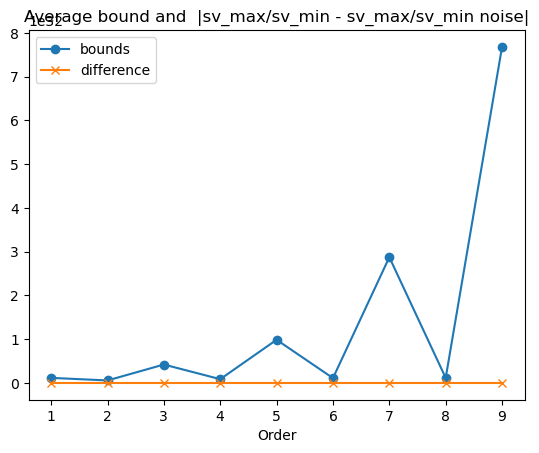

In [63]:
plt.title("Average bound and  |sv_max/sv_min - sv_max/sv_min noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='difference')
plt.legend()

##### Plot for each noise level the different orders:

For higher orders the error (at least for small enough noise i.e. noise <=1e-8) gets smaller.
It always gets better from order 1 to some higher order for noise <= 1e-5
If E is very small the approximaitn is not that bad.
Maybe a good lower bound would be 1e-8/1e-9/1e-10???

Note that the difference here revolves around 1e15 (even for low noise levels) which is already pretty high
The difference never gets better after order=6 -> we do not need to consider this.

True ratio: 4.353e+15
Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0
0.0
	 	 1	  	 6.68e-01 	 1.37e+00 	4.35e+15 	1.39475e+29 	 1.326e+03
	 	 2	  	 2.33e-03 	 4.62e-03 	4.35e+15 	4.69612e+26 	 2.465e+05
	 	 3	  	 1.25e-05 	 7.00e-05 	4.35e+15 	7.11534e+24 	 4.858e+07
	 	 4	  	 6.35e-08 	 9.43e-08 	4.35e+15 	9.58328e+21 	 6.482e+09
	 	 5	  	 4.37e-10 	 4.80e-09 	4.35e+15 	4.87799e+20 	 6.577e+11
	 	 6	  	 3.60e-12 	 6.09e-12 	4.28e+15 	6.18952e+17 	 7.406e+13
	 	 7	  	 3.58e-12 	 1.02e-10 	4.28e+15 	1.03143e+19 	 7.465e+13
	 	 8	  	 5.39e-12 	 4.58e-12 	4.30e+15 	4.65270e+17 	 4.912e+13
	 	 9	  	 8.56e-12 	 2.97e-10 	4.32e+15 	3.01286e+19 	 3.088e+13


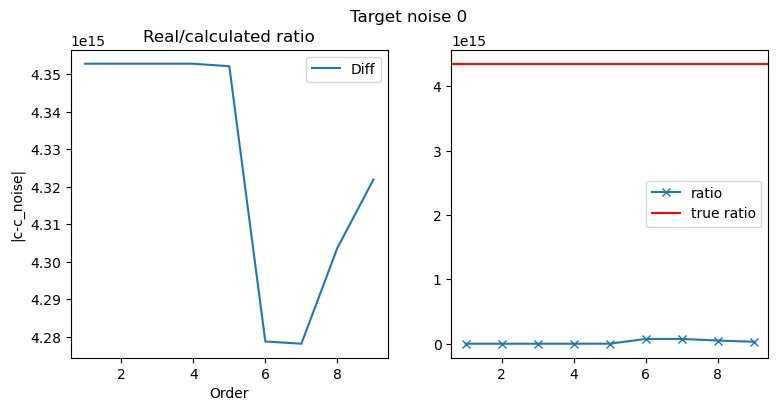

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-10
1.3275733283851251e-08
	 	 1	  	 6.68e-01 	 1.37e+00 	4.35e+15 	1.39476e+29 	 1.326e+03
	 	 2	  	 2.33e-03 	 4.63e-03 	4.35e+15 	4.70199e+26 	 2.465e+05
	 	 3	  	 1.26e-05 	 1.09e-04 	4.35e+15 	1.10258e+25 	 4.623e+07
	 	 4	  	 1.67e-06 	 8.75e-06 	4.35e+15 	8.89438e+23 	 1.579e+08
	 	 5	  	 2.25e-06 	 9.85e-05 	4.35e+15 	1.00113e+25 	 1.172e+08
	 	 6	  	 2.81e-06 	 1.06e-05 	4.35e+15 	1.07538e+24 	 9.370e+07
	 	 7	  	 4.15e-06 	 2.66e-04 	4.35e+15 	2.69934e+25 	 6.354e+07
	 	 8	  	 6.51e-06 	 1.20e-05 	4.35e+15 	1.22202e+24 	 4.049e+07
	 	 9	  	 1.10e-05 	 7.79e-04 	4.35e+15 	7.91329e+25 	 2.397e+07


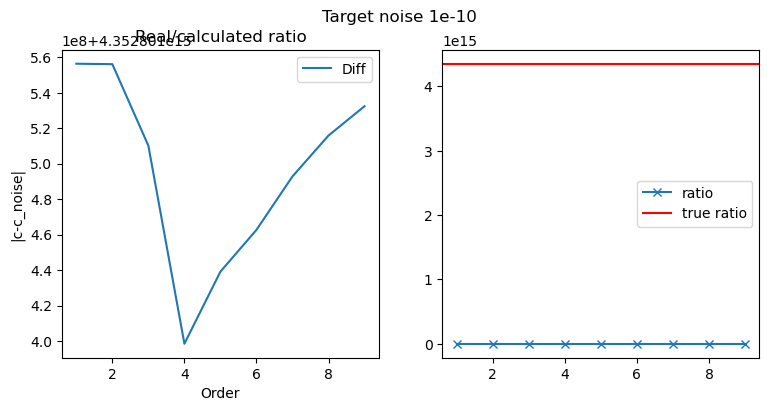

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-09
1.336038698564346e-07
	 	 1	  	 6.68e-01 	 1.37e+00 	4.35e+15 	1.39486e+29 	 1.326e+03
	 	 2	  	 2.33e-03 	 4.68e-03 	4.35e+15 	4.74995e+26 	 2.465e+05
	 	 3	  	 2.09e-05 	 4.23e-04 	4.35e+15 	4.30007e+25 	 1.488e+07
	 	 4	  	 1.61e-05 	 7.96e-05 	4.35e+15 	8.08380e+24 	 1.634e+07
	 	 5	  	 2.17e-05 	 9.04e-04 	4.35e+15 	9.18670e+25 	 1.213e+07
	 	 6	  	 2.70e-05 	 9.71e-05 	4.35e+15 	9.86849e+24 	 9.780e+06
	 	 7	  	 3.93e-05 	 2.44e-03 	4.35e+15 	2.47712e+26 	 6.714e+06
	 	 8	  	 6.01e-05 	 1.10e-04 	4.35e+15 	1.12142e+25 	 4.389e+06
	 	 9	  	 9.94e-05 	 7.15e-03 	4.35e+15 	7.26183e+26 	 2.655e+06


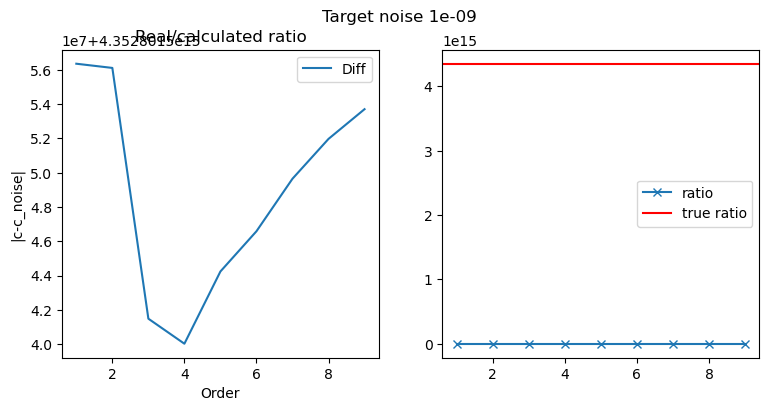

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-08
1.3162727667230655e-06
	 	 1	  	 6.68e-01 	 1.37e+00 	4.35e+15 	1.39579e+29 	 1.326e+03
	 	 2	  	 2.33e-03 	 5.13e-03 	4.35e+15 	5.21573e+26 	 2.454e+05
	 	 3	  	 1.69e-04 	 3.48e-03 	4.35e+15 	3.53521e+26 	 1.562e+06
	 	 4	  	 1.64e-04 	 7.67e-04 	4.35e+15 	7.79511e+25 	 1.606e+06
	 	 5	  	 2.22e-04 	 8.73e-03 	4.35e+15 	8.86800e+26 	 1.186e+06
	 	 6	  	 2.81e-04 	 9.38e-04 	4.35e+15 	9.52618e+25 	 9.394e+05
	 	 7	  	 4.15e-04 	 2.35e-02 	4.35e+15 	2.39119e+27 	 6.360e+05
	 	 8	  	 6.43e-04 	 1.07e-03 	4.35e+15 	1.08252e+26 	 4.103e+05
	 	 9	  	 1.06e-03 	 6.90e-02 	4.35e+15 	7.00994e+27 	 2.481e+05


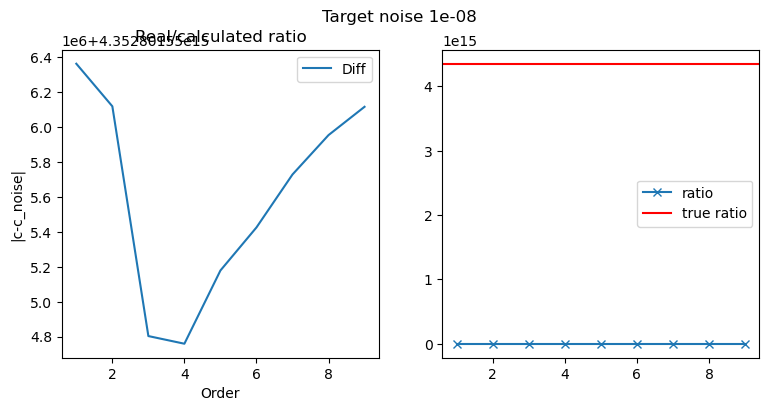

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-07
1.3152182224816327e-05
	 	 1	  	 6.68e-01 	 1.38e+00 	4.35e+15 	1.40554e+29 	 1.326e+03
	 	 2	  	 2.53e-03 	 9.93e-03 	4.35e+15 	1.00912e+27 	 1.817e+05
	 	 3	  	 1.64e-03 	 3.55e-02 	4.35e+15 	3.60383e+27 	 1.600e+05
	 	 4	  	 1.56e-03 	 7.97e-03 	4.35e+15 	8.09272e+26 	 1.689e+05
	 	 5	  	 2.10e-03 	 9.06e-02 	4.35e+15 	9.20759e+27 	 1.255e+05
	 	 6	  	 2.61e-03 	 9.74e-03 	4.35e+15 	9.89098e+26 	 1.010e+05
	 	 7	  	 3.83e-03 	 2.44e-01 	4.35e+15 	2.48276e+28 	 6.892e+04
	 	 8	  	 5.87e-03 	 1.11e-02 	4.35e+15 	1.12397e+27 	 4.493e+04
	 	 9	  	 9.68e-03 	 7.16e-01 	4.35e+15 	7.27838e+28 	 2.724e+04


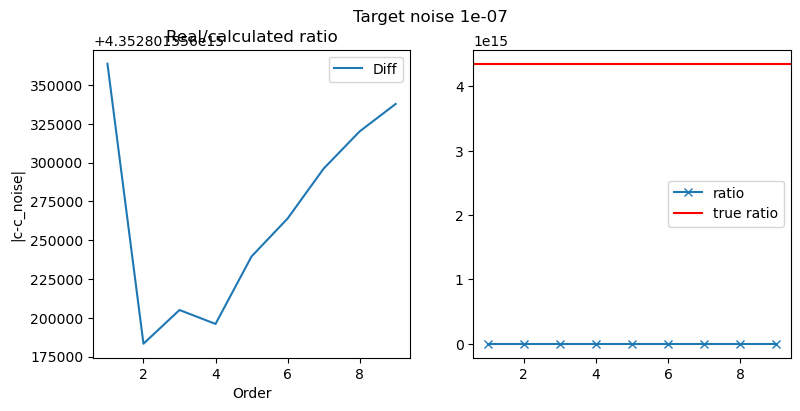

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-06
0.00013368230528678873
	 	 1	  	 6.68e-01 	 1.49e+00 	4.35e+15 	1.51296e+29 	 1.319e+03
	 	 2	  	 1.08e-02 	 6.28e-02 	4.35e+15 	6.38014e+27 	 2.496e+04
	 	 3	  	 1.71e-02 	 3.88e-01 	4.35e+15 	3.94105e+28 	 1.542e+04
	 	 4	  	 1.65e-02 	 8.73e-02 	4.35e+15 	8.86579e+27 	 1.595e+04
	 	 5	  	 2.22e-02 	 9.93e-01 	4.35e+15 	1.00873e+29 	 1.189e+04
	 	 6	  	 2.77e-02 	 1.07e-01 	4.35e+15 	1.08360e+28 	 9.529e+03
	 	 7	  	 4.09e-02 	 2.68e+00 	4.35e+15 	2.71996e+29 	 6.448e+03
	 	 8	  	 6.38e-02 	 1.21e-01 	4.35e+15 	1.23136e+28 	 4.132e+03
	 	 9	  	 1.06e-01 	 7.85e+00 	4.35e+15 	7.97375e+29 	 2.480e+03


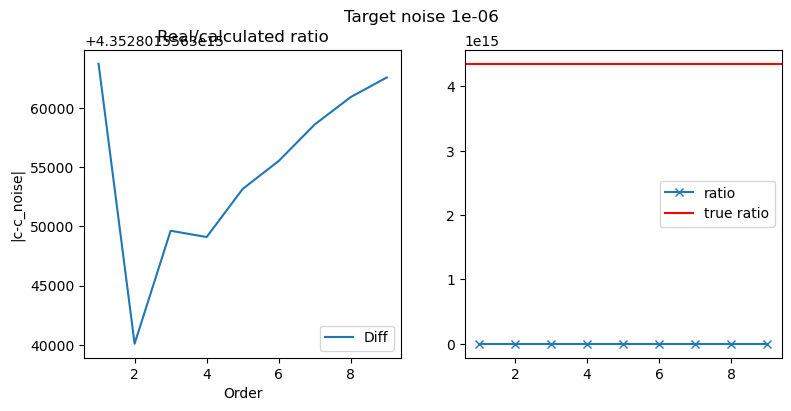

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
1e-05
0.0013200530191310653
	 	 1	  	 6.93e-01 	 2.29e+00 	4.35e+15 	2.32334e+29 	 9.708e+02
	 	 2	  	 1.03e-01 	 4.62e-01 	4.35e+15 	4.68994e+28 	 2.557e+03
	 	 3	  	 1.68e-01 	 3.05e+00 	4.35e+15 	3.09538e+29 	 1.564e+03
	 	 4	  	 1.63e-01 	 6.86e-01 	4.35e+15 	6.96446e+28 	 1.618e+03
	 	 5	  	 2.23e-01 	 7.80e+00 	4.35e+15 	7.92399e+29 	 1.182e+03
	 	 6	  	 2.85e-01 	 8.38e-01 	4.35e+15 	8.51211e+28 	 9.268e+02
	 	 7	  	 4.20e-01 	 2.10e+01 	4.35e+15 	2.13665e+30 	 6.280e+02
	 	 8	  	 6.44e-01 	 9.52e-01 	4.35e+15 	9.67285e+28 	 4.093e+02
	 	 9	  	 1.05e+00 	 6.17e+01 	4.35e+15 	6.26373e+30 	 2.507e+02


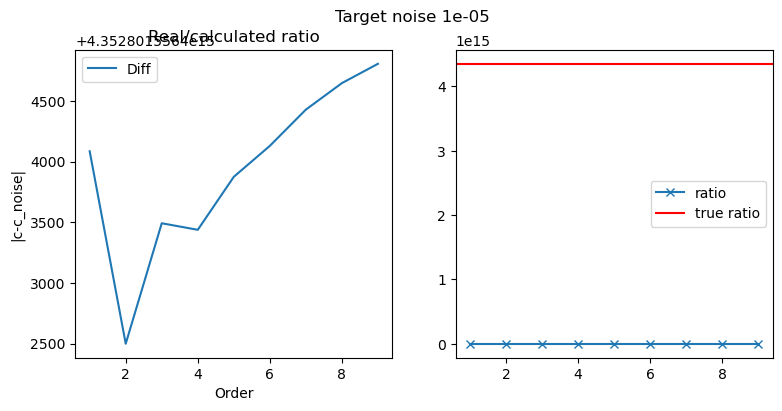

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.0001
0.013284067560240129
	 	 1	  	 1.98e+00 	 1.15e+01 	4.35e+15 	1.16898e+30 	 1.407e+02
	 	 2	  	 1.03e+00 	 5.07e+00 	4.35e+15 	5.15225e+29 	 2.553e+02
	 	 3	  	 1.70e+00 	 3.38e+01 	4.35e+15 	3.43170e+30 	 1.549e+02
	 	 4	  	 1.64e+00 	 7.60e+00 	4.35e+15 	7.72131e+29 	 1.604e+02
	 	 5	  	 2.22e+00 	 8.65e+01 	4.35e+15 	8.78512e+30 	 1.186e+02
	 	 6	  	 2.79e+00 	 9.29e+00 	4.35e+15 	9.43715e+29 	 9.464e+01
	 	 7	  	 4.11e+00 	 2.33e+02 	4.35e+15 	2.36885e+31 	 6.420e+01
	 	 8	  	 6.39e+00 	 1.06e+01 	4.35e+15 	1.07240e+30 	 4.128e+01
	 	 9	  	 1.07e+01 	 6.84e+02 	4.35e+15 	6.94443e+31 	 2.472e+01


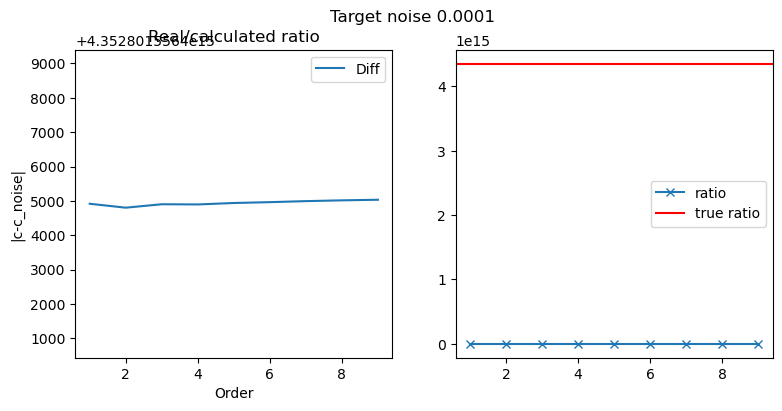

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.001
0.13205304614316254
	 	 1	  	 1.85e+01 	 1.11e+02 	4.35e+15 	1.12479e+31 	 1.432e+01
	 	 2	  	 1.04e+01 	 5.47e+01 	4.35e+15 	5.55468e+30 	 2.542e+01
	 	 3	  	 1.70e+01 	 3.64e+02 	4.35e+15 	3.70279e+31 	 1.552e+01
	 	 4	  	 1.68e+01 	 8.20e+01 	4.35e+15 	8.33130e+30 	 1.577e+01
	 	 5	  	 2.28e+01 	 9.33e+02 	4.35e+15 	9.47915e+31 	 1.166e+01
	 	 6	  	 2.86e+01 	 1.00e+02 	4.35e+15 	1.01827e+31 	 9.329e+00
	 	 7	  	 4.13e+01 	 2.52e+03 	4.35e+15 	2.55599e+32 	 6.529e+00
	 	 8	  	 6.27e+01 	 1.14e+02 	4.35e+15 	1.15712e+31 	 4.439e+00
	 	 9	  	 1.03e+02 	 7.38e+03 	4.35e+15 	7.49304e+32 	 2.986e+00


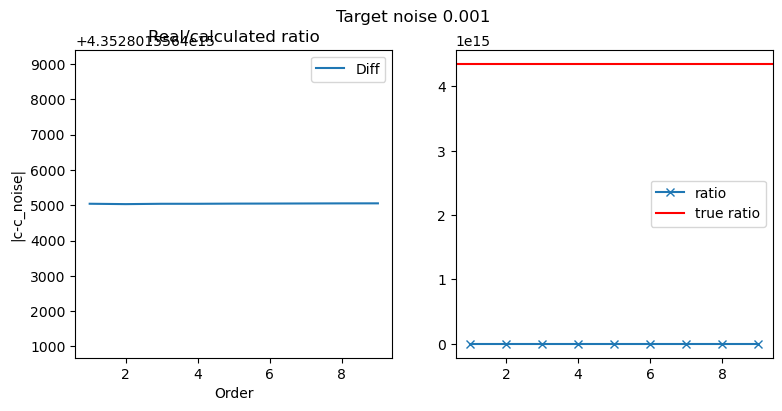

Noise level 	 order 	 	 |g-g_noise| 	 sqrt(E) 	|c-c_noise| 	 Bound 	 	 ratio
0.01
1.3131007980300216
	 	 1	  	 1.85e+02 	 1.01e+03 	4.35e+15 	1.02409e+32 	 2.404e+00
	 	 2	  	 1.03e+02 	 5.03e+02 	4.35e+15 	5.11352e+31 	 3.002e+00
	 	 3	  	 1.69e+02 	 3.36e+03 	4.35e+15 	3.40897e+32 	 2.414e+00
	 	 4	  	 1.65e+02 	 7.55e+02 	4.35e+15 	7.67019e+31 	 2.428e+00
	 	 5	  	 2.25e+02 	 8.59e+03 	4.35e+15 	8.72696e+32 	 2.453e+00
	 	 6	  	 2.87e+02 	 9.23e+02 	4.35e+15 	9.37468e+31 	 2.707e+00
	 	 7	  	 4.29e+02 	 2.32e+04 	4.35e+15 	2.35316e+33 	 3.559e+00
	 	 8	  	 6.69e+02 	 1.05e+03 	4.35e+15 	1.06530e+32 	 5.250e+00
	 	 9	  	 1.10e+03 	 6.79e+04 	4.35e+15 	6.89846e+33 	 8.463e+00


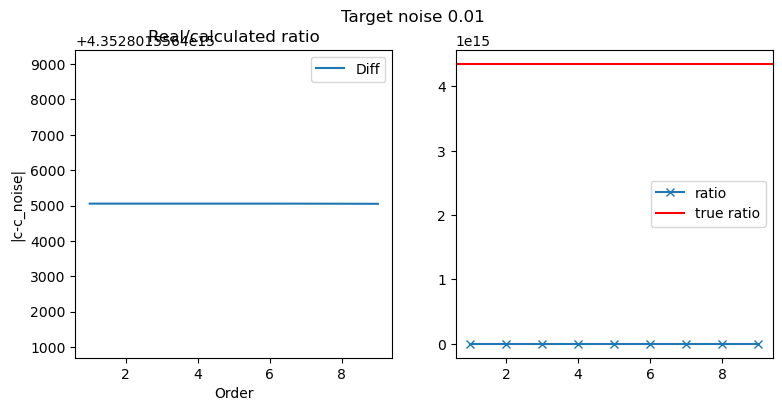

In [69]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t |g-g_noise| \t sqrt(E) \t|c-c_noise| \t Bound \t \t ratio")
    print(f"{target_noise}")
    diff_list = []
    bound_list = []
    ratio_list=[]
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    
    for order in orders:        
        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
        sv = svd(g_noise, compute_uv=False)
        ratio=sv[0]/sv[-1]
        
        bound = error_bound_condition(E,sv_max,sv_min)
        diff = np.abs(ratio-true_ratio)
        bound_list.append(bound)
        diff_list.append(diff)
        ratio_list.append(ratio)
        
        print(f"\t \t {order}\t  \t {np.linalg.norm(true_g-g_noise):3.2e} \t {np.sqrt(E):3.2e} \t{diff:3.2e} \t{bound:3.5e} \t {ratio:3.3e}")

    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.suptitle(f"Target noise {target_noise}")
    plt.title("Difference real/calculated condition")
    plt.plot(orders,diff_list,label="Diff")
    #plt.plot(orders,bound_list,label="bound")
    plt.legend()
    #plt.yscale('log')
    plt.title("Real/calculated ratio")
    plt.xlabel('Order')
    plt.ylabel('|c-c_noise|')
    plt.subplot(1,2,2)
    plt.plot(orders,ratio_list, marker='x',label="ratio")
    plt.axhline(y=true_ratio, color='r', label='true ratio')
    plt.legend()
    plt.show()

##### lets look at one specific example to find the reason for the "knick": 
the reason for the knick comes from the error in finite differences (see more in the finite differences section)

In [26]:
target_noise=1e-7
orders=range(1,10,1)
print(f"SV_min: {sv_min}, SV_max: {sv_max}, Ratio {sv_max/sv_min}")
df = pd.DataFrame(columns = ['order','|g-g_noise|', 'E', '|c-c_noise|','bound','ratio','sv_max','sv_min','ux-ux_noise','boundux','sv_min - |ux-ux_noise|'])
print(f"{target_noise}")
var = target_noise * unorm2
noise = np.random.normal(0, var, size=u.shape)
print(np.linalg.norm(noise))
u_noise = u + noise
eps_two = np.linalg.norm(u-u_noise)
eps_infty = infinity_norm(u_noise-u)
M=infinity_norm(uxxx)

for order in orders:  
    print(f"order {order}")
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
    g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
    E=error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order)
    sv = svd(g_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = error_bound_condition(E,sv_max,sv_min)
    diff = np.abs(ratio-sv_max/sv_min)
    boundux = np.sqrt(true_g.shape[0])*error_bound_finite_diff(eps_infty,dx,M,order)
    new_row = {'order': order, '|g-g_noise|': np.linalg.norm(true_g-g_noise), 'E': np.sqrt(E), '|c-c_noise|': diff,'bound':bound,'ratio':ratio,'sv_max':sv[0],
               'sv_min':sv[-1],'ux-ux_noise':np.linalg.norm(ux-ux_noise),'boundux':boundux,'sv_min - |ux-ux_noise|': np.abs(sv_min - np.linalg.norm(ux-ux_noise))}
    df.loc[len(df)] = new_row
    
print(df)

SV_min: 1.680559098890283e-14, SV_max: 205.59100528590918, Ratio 1.2233488570658794e+16
1e-07
1.4482221552629386e-05
order 1
order 2
order 3
order 4
order 5
order 6
order 7
order 8
order 9
   order  |g-g_noise|         E   |c-c_noise|         bound          ratio  \
0      1     0.736586  1.384699  1.223349e+16  1.007980e+30    1325.491364   
1      2     0.002821  0.010537  1.223349e+16  7.670397e+27  174317.458557   
2      3     0.001875  0.039501  1.223349e+16  2.875439e+28  154661.758781   
3      4     0.001829  0.008872  1.223349e+16  6.458344e+27  158986.462235   
4      5     0.002455  0.100943  1.223349e+16  7.348073e+28  118311.497727   
5      6     0.003053  0.010844  1.223349e+16  7.893444e+27   95249.567647   
6      7     0.004418  0.272186  1.223349e+16  1.981355e+29   65790.641212   
7      8     0.006729  0.012322  1.223349e+16  8.969821e+27   43212.872138   
8      9     0.011037  0.797932  1.223349e+16  5.808476e+29   26345.208966   

       sv_max    sv_min  ux-ux

No handles with labels found to put in legend.


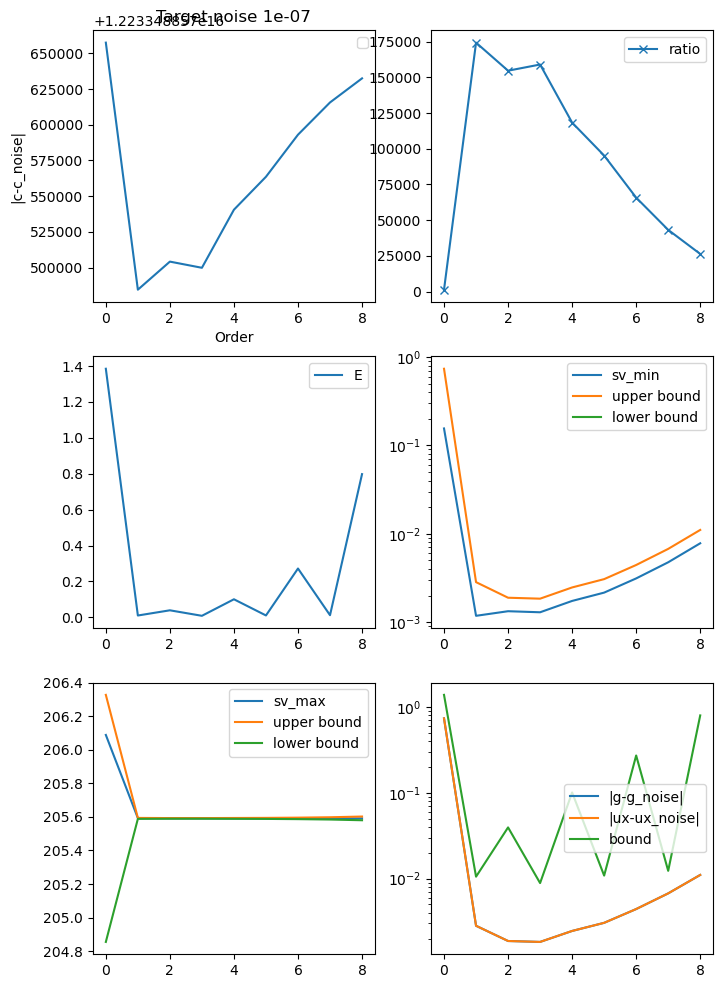

In [27]:
plt.figure(figsize=(8,12))
plt.subplot(3,2,1)
plt.title(f"Target noise {target_noise}")
plt.plot(df["|c-c_noise|"])
plt.legend()
plt.xlabel('Order')
plt.ylabel('|c-c_noise|')
plt.subplot(3,2,2)
plt.plot(df["ratio"], marker='x',label='ratio')
#plt.axhline(y=sv_max/sv_min, color='r', label='true ratio')
plt.legend()
plt.subplot(3,2,3)
plt.plot(df["E"],label='E')
plt.legend()
plt.subplot(3,2,4)
plt.plot(df["sv_min"],label='sv_min')
plt.plot(sv_min + (df["ux-ux_noise"]+eps_two),label='upper bound')
plt.plot(sv_min - (df["ux-ux_noise"]+eps_two),label='lower bound')#if it is negative nothing will be ploted
#plt.plot(df["ux-ux_noise"],label='|ux-ux_noise|')
plt.yscale('log')
plt.legend()
plt.subplot(3,2,5)
plt.plot(df["sv_max"],label='sv_max')
plt.plot(sv_max + (df["ux-ux_noise"]+eps_two),label='upper bound')
plt.plot(sv_max - (df["ux-ux_noise"]+eps_two),label='lower bound')
plt.legend()
plt.subplot(3,2,6)
plt.plot(df["|g-g_noise|"],label='|g-g_noise|')
plt.plot(df["ux-ux_noise"],label='|ux-ux_noise|')
plt.plot(df['boundux'],label='bound')# currently bound is wrong why???
plt.yscale('log')
plt.legend()
plt.show()